<a href="https://colab.research.google.com/github/tobieabel/robokeeper/blob/master/TF2_Object_Detection_from_Checkpoint_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is from https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tflite.ipynb
its TF2 object detection using a saved checkpoint.  Its different from the other examples because it loads all data as numpy arrays. This was originally used when you only have a handful of training images. Currently this only works for a single class and a single box per image

In [ ]:
!pip install tf-nightly

     |████████████████████████████████| 400.5MB 46kB/s 
     |████████████████████████████████| 4.0MB 49.0MB/s 
     |████████████████████████████████| 471kB 34.1MB/s 
     |████████████████████████████████| 4.0MB 36.2MB/s 
     |████████████████████████████████| 12.2MB 236kB/s 
ERROR: tensorflow 2.4.0 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models


Cloning into 'models'...
remote: Enumerating objects: 2404, done.
remote: Counting objects: 100% (2404/2404), done.
remote: Compressing objects: 100% (2001/2001), done.
remote: Total 2404 (delta 569), reused 1415 (delta 376), pack-reused 0
Receiving objects: 100% (2404/2404), 30.77 MiB | 17.03 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1613291 sha256=238a972b5f94314783ddf1eb8d9a6fefeb4a02498c363c6c5dd37c6d773630af
  Stored in directory: /tmp/pip-ephem-wheel-cache-93gbh1y5/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp36-none-any.whl size=43734 sha256=628b0f5c10d21b9bfe67975629573a59cb8bd38876fe64498a1c5e9281d4e285
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78533 sha256=9376db06d41a0fe423d66ceead95d3f4b573bca36d2f7bef3888037d92f7bffe
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for hdfs: filename=hdfs-2.5.8-cp36-none-any.whl size=33213 sha256=7c1b3a4075100e6a52d35ee399167c85b4c1ee3f8075390072b810741b

ERROR: tf-nightly 2.5.0.dev20210119 has requirement gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20210119 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.27.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import shutil
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

!pip install xmltodict
import xmltodict

%matplotlib inline

Load images jpgs and xml into google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
data_root = tf.keras.utils.get_file(origin='file:///content/drive/My Drive/Robotics/Ball.zip',
                                         fname = 'Ball.zip',archive_format='zip',extract=False)
data_root = pathlib.Path('/root/.keras/datasets/Ball.zip')

481681408/481679080 [==============================] - 4s 0us/step


In [ ]:
mkdir models/research/object_detection/test_images/ducky/train/ball

In [ ]:
shutil.move('/root/.keras/datasets/Ball.zip', '/content/models/research/object_detection/test_images/ducky/train/ball/Ball.zip')


'/content/models/research/object_detection/test_images/ducky/train/ball/Ball.zip'

In [ ]:
cd models/research/object_detection/test_images/ducky/train/ball

/content/models/research/object_detection/test_images/ducky/train/ball


Manually upload BallXML.zip before running next step

In [ ]:
!unzip -q Ball.zip
!unzip -q BallXML.zip

In [ ]:
import cv2 #Can amend the image before using it to create tensor records

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  print(path)
  img_data = tf.io.gfile.GFile(path, 'rb').read()#open jpg file into tf object
  im=np.array(Image.open(BytesIO(img_data)))#then open the tf object as a PIL image and convert to ndarray
  #if you want to manipulate images further then do it here, but much easier to do that before loading
  #blur the image, then subtract it from the original image.
  #blur_img = cv2.GaussianBlur(im,(13,13),10)
  #im = blur_img-im
  #reshape ndarray if necessary - not sure what shape and type the ndarray is after manipulation..?
  #print(type(im))
  #print(im.shape)
  #(im_width, im_height) = im.size
  image =  im.astype(np.uint8)
  return image
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [ ]:
ls

Ball/  BallXML/  BallXML.zip  Ball.zip  __MACOSX/


Created a couple of functions for using with sorting image names by name and then by number

In [ ]:
def name(x):
   new_name = x.replace("ball",".")
   name_list = new_name.split(".")
   return name_list[0]

def number(x):
    new_name = x.replace("ball", ".")
    name_list = new_name.split(".")
    return int(name_list[1])

/content/models/research/object_detection/test_images/ducky/train/ball/Ball/ball001.jpg
/content/models/research/object_detection/test_images/ducky/train/ball/Ball/ball002.jpg
/content/models/research/object_detection/test_images/ducky/train/ball/Ball/ball003.jpg
/content/models/research/object_detection/test_images/ducky/train/ball/Ball/ball004.jpg
/content/models/research/object_detection/test_images/ducky/train/ball/Ball/ball005.jpg


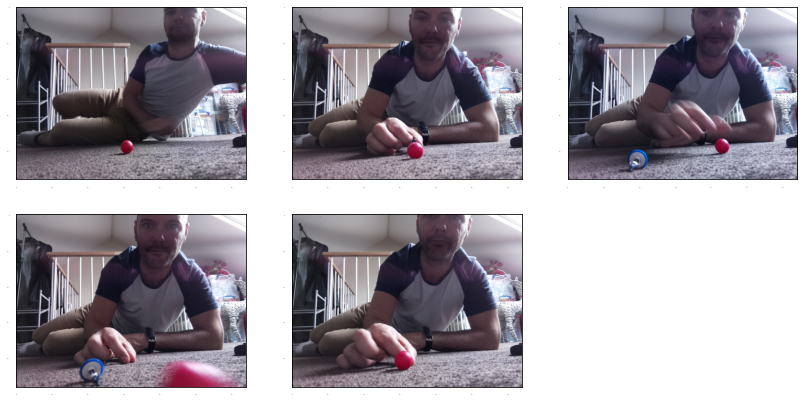

In [ ]:
# Load images and visualize
train_image_dir = '/content/models/research/object_detection/test_images/ducky/train/ball/Ball/'
images = [i for i in os.listdir(train_image_dir)if i != '.DS_Store']#list comprehension to create list of file names in a directory.  Exclude 'DS_Store'
#Sort list by filename to ensure images and bounding boxes are synced
images = sorted(images,key=lambda x:(name(x),number(x)))#sort by name function, and then by number function.
train_images_np = []
for i in images[:5]:
  if i != ".DS_Store":
    image_path = os.path.join(train_image_dir, i)
    train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

load xml into ndarrays - need to ensure the  xmin, ymin, xmas, ymax order in gt_boxes on xml file is changed to ymin, xmin, ymax, xmax for tensors.  Also ensure you sort the files by file name to ensure the image tensors and xml tensors match (currently list comprehension is returning in random order)

In [ ]:
xmin=""
ymin=""
xmax=""
ymax=""
xml_list = []
xml_list_2 = [] 
gt_boxes = []
xmlsource = "/content/models/research/object_detection/test_images/ducky/train/ball/BallXML"
xml_files = [i for i in os.listdir(xmlsource)if i != '.DS_Store']#create list, exclude file 'DS.Store'
#Sort this list by filename to ensure image and bbox are synced
xml_files = sorted(xml_files,key=lambda x:(name(x),number(x)))#use same name and number functions as .jpg file sorting

for i in xml_files[:5]:
    with open(xmlsource + '/' + i,"r")as f:
        if i != '.DS_Store':#folder some has some wierd file in it called .DS_Store
          data_dict = xmltodict.parse(f.read())#this turns xml into a dictionary
          for y in (data_dict['annotation']['object']['bndbox']['ymin']):#check the xml file to see structure
              ymin += y
              
          xml_list.append(int(ymin)/480)#tf expects floating point so divide xy coordinates by width
          ymin = ""
          
          for x in (data_dict['annotation']['object']['bndbox']['xmin']):#check the xml file to see structure
              xmin += x
              
          xml_list.append(int(xmin)/640)#tf expects floating point so divide xy coordinates by height
          xmin = ""
          
          for y in (data_dict['annotation']['object']['bndbox']['ymax']):#check the xml file to see structure
              ymax += y
              
          xml_list.append(int(ymax)/480)#tf expects floating point so divide xy coordinates by width
          ymax =""

          for x in (data_dict['annotation']['object']['bndbox']['xmax']):#check the xml file to see structure
              xmax += x
              
          xml_list.append(int(xmax)/640)#tf expects floating point so divide xy coordinates by height
          xmax = ""
          
          print("file {} = {}".format(i,xml_list))
          xml_list_2.append(xml_list)#The tensor has to be a list containing a list containing tensors, hense two lists
          np_xml = np.array(xml_list_2,dtype = np.float32)
          gt_boxes.append(np_xml)
          xml_list = []#clear list before next file in loop
          xml_list_2 = []
#print(gt_boxes)


file ball001.xml = [0.775, 0.45625, 0.85625, 0.5125]
file ball002.xml = [0.7895833333333333, 0.5046875, 0.8791666666666667, 0.5671875]
file ball003.xml = [0.7645833333333333, 0.6375, 0.8583333333333333, 0.703125]
file ball004.xml = [0.8541666666666666, 0.6609375, 1.0, 0.884375]
file ball005.xml = [0.7875, 0.4515625, 0.9, 0.525]


try and convert the images and xml into tensors

In [ ]:
num_classes = 2
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


Need to manually add additional classes to the category_index dictionary


In [ ]:
Ball_class_id = 1
category_index = {Ball_class_id: {'id': Ball_class_id, 'name': 'Ball'}}
White_Ball_class_id = 2
category_index[White_Ball_class_id] = {'id': White_Ball_class_id, 'name': 'White_Ball'}
print(category_index)

{1: {'id': 1, 'name': 'Ball'}, 2: {'id': 2, 'name': 'White_Ball'}}


In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, 
      category_index)
plt.show()

Need to be at "/content" directory before runing next steps (may need to run cd../ multiple times)

In [ ]:
cd ../

/content


change the download model to be either 320x320 or 640x640

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-01-20 08:18:29--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.119.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  21.8MB/s    in 0.9s    

2021-01-20 08:18:30 (21.8 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



Need to update the below block and ensure they reflect the correct SSD model (320x320 or 640x640)
Also update num_classes if adding classes (e.g. white ball, red ball etc)

In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 2
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# two for our ball and white_ball classes). Below will directly edit the config file and save new version
# under the "output" directory
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
# Save new pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# Set up object-based checkpoint restore --- SSD has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads) 
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# To save checkpoint for TFLite conversion.
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
INFO:tensorflow:Writing pipeline config file to output/pipeline.config
Weights restored!


In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 5
learning_rate = 0.15
num_batches = 1000

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.
 Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 100 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:440: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Start fine-tuning!
batch 0 of 1000, loss=1.2605445
batch 100 of 1000, loss=0.02649079
batch 200 of 1000, loss=0.0105259465
batch 300 of 1000, loss=0.005633541
batch 400 of 1000, loss=0.0035557055
batch 500 of 1000, loss=0.0024903947
batch 600 of 1000, loss=0.001868542
batch 700 of 1000, loss=0.0014708419
batch 800 of 1000, loss=0.0011990034
batch 900 of 1000, loss=0.0010036363
Done fine-tuning!
Checkpoint saved!


Convert the model to TFLite

In [ ]:
%%bash
python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path output/pipeline.config \
  --trained_checkpoint_dir output/checkpoint \
  --output_directory tflite

2021-01-20 09:51:54.999830: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-01-20 09:51:54.999974: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-01-20 09:51:57.532381: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-20 09:51:57.546044: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-01-20 09:51:57.546192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ee6c95b26c56): /proc/driver/nvidia/version does not exist
2021-01-20 09:51:57.546661: I tensorflow/c

In [ ]:
!tflite_convert --saved_model_dir=tflite/saved_model --output_file=tflite/model.tflite

2021-01-20 09:15:27.944070: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-01-20 09:15:27.944128: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-01-20 09:15:30.847427: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-20 09:15:30.860660: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-01-20 09:15:30.860726: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ee6c95b26c56): /proc/driver/nvidia/version does not exist
2021-01-20 09:15:30.861110: I tensorflow/c

download TFLite model

In [ ]:
from google.colab import files
files.download('tflite/model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Perform post training quantisation

In [ ]:
saved_model_dir = "/content/tflite/saved_model"

In [ ]:
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files("/content/models/research/object_detection/test_images/ducky/train/ball/Ball/*.jpg")
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [640, 640])
    #image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.allow_custom_ops = True
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

In [ ]:
open("Quant_converted_model.tflite", "wb").write(tflite_model)

4474120

Download EDGETPU complier

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1974  100  1974    0     0  32360      0 --:--:-- --:--:-- --:--:-- 32360
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ge

In [ ]:
! edgetpu_compiler Quant_converted_model.tflite

Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 2182 ms.

Input model: Quant_converted_model.tflite
Input size: 4.27MiB
Output model: Quant_converted_model_edgetpu.tflite
Output size: 4.74MiB
On-chip memory used for caching model parameters: 3.21MiB
On-chip memory remaining for caching model parameters: 3.78MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 167
Operation log: Quant_converted_model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 118
Number of operations that will run on CPU: 49
See the operation log file for individual operation details.


In [ ]:
from google.colab import files
files.download('Quant_converted_model_edgetpu.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test the model

In [ ]:
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
def detect(interpreter, input_tensor):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  return boxes, classes, scores

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = detect(interpreter, input_tensor)

  plot_detections(
      test_images_np[i][0],
      boxes[0],
      classes[0].astype(np.uint32) + label_id_offset,
      scores[0],
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))